# Projet de prédiction des données liées au Covid

Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import plotly.io as pio
pio.renderers.default = 'iframe_connected'

In [2]:
df_raw_confirmed_global = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
df_raw_deaths_global = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df_raw_vaccination_global = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv")
df_raw_vaccination_global=df_raw_vaccination_global.drop(columns=["daily_vaccinations_per_million","total_boosters_per_hundred","daily_vaccinations_raw","total_boosters","people_fully_vaccinated_per_hundred","daily_people_vaccinated_per_hundred","people_vaccinated", "total_vaccinations", "daily_people_vaccinated", "people_fully_vaccinated","total_vaccinations_per_hundred","people_vaccinated_per_hundred"])


In [3]:
# Choose latitude and longitude for the chosen country
lat_min = 41.317
lat_max = 51.07167
long_min = -5.14028
long_max = 9.51333

In [4]:
# Function to filter elements by latitude/longitude
def check_lat_long(df, lat_min, lat_max, long_min, long_max):
   return df[(df["Lat"] > lat_min) & (df["Lat"] < lat_max) & (df["Long"] > long_min) & (df["Long"] < long_max)]

In [5]:
country = "France"

df_raw_confirmed_country = df_raw_confirmed_global[df_raw_confirmed_global["Country/Region"] == country]
df_raw_deaths_country = df_raw_deaths_global[df_raw_deaths_global["Country/Region"] == country]
df_raw_vaccination_country = df_raw_vaccination_global[df_raw_vaccination_global["location"] == country]
#df_confirmed_country = df_raw_confirmed_country
#df_deaths_country = df_raw_deaths_country
df_confirmed_country = check_lat_long(df_raw_confirmed_country, lat_min ,lat_max ,long_min, long_max)
df_deaths_country = check_lat_long(df_raw_deaths_country, lat_min, lat_max, long_min, long_max)

In [6]:
uselessColumns = ["Lat", "Long", "Province/State", "Country/Region"]

def columnsInNumbers(df):
  df.columns = [i for i in range(len(df_confirmed_country.columns))]

df_confirmed_country = df_confirmed_country.drop(columns=uselessColumns)
df_deaths_country = df_deaths_country.drop(columns=uselessColumns)

columnsInNumbers(df_confirmed_country)
columnsInNumbers(df_deaths_country)


df_confirmed_country

,0,1,2,3,4,5,6,7,8,9,...,666,667,668,669,670,671,672,673,674,675
130,0,0,2,3,3,3,4,5,5,5,...,7168026,7188721,7211399,7231148,7235966,7266361,7296757,7330086,7364380,7364380


In [7]:
def get_values_and_days(df):
  return (df.values[0], df.columns.to_list())

confirmed_country_values, confirmed_country_days = get_values_and_days(df_confirmed_country)
deaths_country_values, deaths_country_days = get_values_and_days(df_deaths_country)
vaccination_index_values = list(df_raw_vaccination_country.daily_vaccinations)[:len(confirmed_country_values)]
vaccination_index_days = [i for i in range(df_raw_vaccination_country.date.size)]


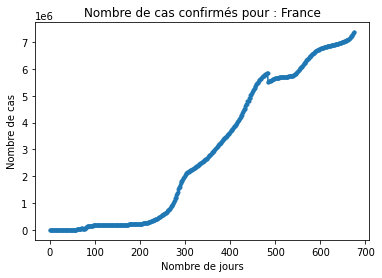

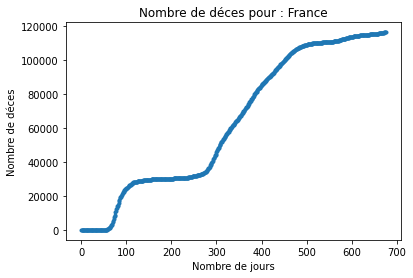

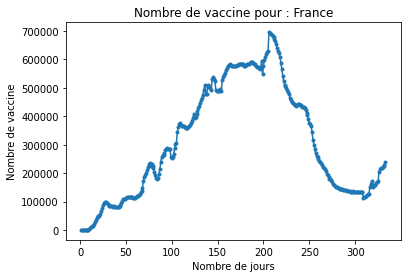

In [8]:
plt.plot(confirmed_country_days, confirmed_country_values, '.-')
plt.title("Nombre de cas confirmés pour : " + country)
plt.xlabel("Nombre de jours")
plt.ylabel("Nombre de cas")
plt.show()

plt.plot(deaths_country_days, deaths_country_values, '.-')
plt.title("Nombre de déces pour : " + country)
plt.xlabel("Nombre de jours")
plt.ylabel("Nombre de déces")
plt.show()

plt.plot(vaccination_index_days, vaccination_index_values, '.-')
plt.title("Nombre de vaccine pour : " + country)
plt.xlabel("Nombre de jours")
plt.ylabel("Nombre de vaccine")
plt.show()

Training and test sets


In [9]:
from sklearn.model_selection import train_test_split

confirmed_train, confirmed_test, confirmed_train_days, confirmed_test_days = train_test_split(confirmed_country_values, confirmed_country_days, test_size=0.30, shuffle=False)
deaths_train, deaths_test, deaths_train_days, deaths_test_days = train_test_split(deaths_country_values, deaths_country_days, test_size=0.30, shuffle=False)

# Regression polynomiale (degré = 2)

In [10]:
import numpy as np
from sklearn import svm

In [11]:
def regression(X, Y):
  reg = svm.SVR(kernel='poly', C=1000, degree=2)
  reg.fit(X, Y)
  return reg

reg_confirmed = regression(np.reshape(confirmed_train_days, newshape=(-1, 1)), confirmed_train)
reg_deaths = regression(np.reshape(deaths_train_days, newshape=(-1, 1)), deaths_train)

print("Regression cas : ", reg_confirmed.score(np.reshape(confirmed_test_days, newshape=(-1, 1)), confirmed_test))
print("Regression morts : ", reg_deaths.score(np.reshape(deaths_test_days, newshape=(-1, 1)), deaths_test))

Regression cas :  -7.018829295450718
Regression morts :  -422.13088428886044


Visualisation des modèles

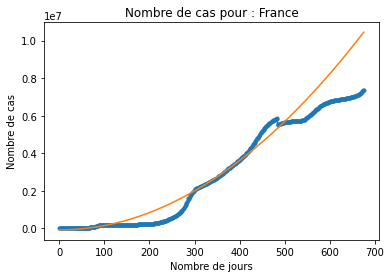

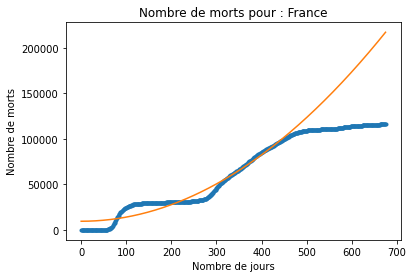

In [12]:
def display_plot(reg, X, Y, ord_context):
  plt.plot(X, Y, '.-')
  plt.plot(X, reg.predict(X), "-")
  plt.title("Nombre de " + ord_context + " pour : " + country)
  plt.xlabel("Nombre de jours")
  plt.ylabel("Nombre de " + ord_context)
  plt.show()

display_plot(reg_confirmed, np.reshape(confirmed_country_days, newshape=(-1, 1)), confirmed_country_values, "cas")
display_plot(reg_deaths, np.reshape(deaths_country_days, newshape=(-1, 1)), deaths_country_values, "morts")

# Réseaux LSTM

In [13]:
import tensorflow as tf
import keras as kr
from sklearn.preprocessing import MinMaxScaler

In [14]:
def create_sequences(data, time_steps=1):
  dataX, dataY = [], []
  for i in range(len(data)-time_steps):
    a = data[i:(i+time_steps)]
    dataX.append(a)
    dataY.append(data[i + time_steps][0])
  return np.array(dataX), np.array(dataY)

def create_lstm_sets(X, time_steps=1, scale=True, train_percent=0.75):
  scaler=None
  if scale:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(X)
    scaled_X = scaler.transform(X)
  else:
    scaled_X = np.array(X)
  train_size = int(len(scaled_X) * train_percent)
  test_size = len(scaled_X) - train_size
  train, test = scaled_X[0:train_size,:], scaled_X[train_size:len(scaled_X),:]
  return create_sequences(train, time_steps), create_sequences(test, time_steps), scaler

def lstm_network(X, Y, time_steps=1, n_features=1):
  model = kr.Sequential()
  model.add(kr.layers.LSTM(100, input_shape=(time_steps, n_features), return_sequences=True)) #return_sequences=True
  model.add(kr.layers.Dropout(0.3))
  model.add(kr.layers.LSTM(100))
  model.add(kr.layers.Dropout(0.3))
  model.add(kr.layers.Dense(1))
  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss='mean_squared_error', optimizer=opt)
  model.summary()
  model.fit(X, Y, epochs=50, batch_size=6);
  return model

## Variable monodimensionelle

In [15]:
time_steps = 1
n_features = 1

### Nombre de cas

In [16]:
confirmed_lstm_set = df_confirmed_country.values[0]
confirmed_lstm_set = np.reshape(confirmed_lstm_set, (len(confirmed_lstm_set), 1))

confirmed_train, confirmed_test, confirmed_scaler = create_lstm_sets(confirmed_lstm_set, time_steps)

confirmed_trainX, confirmed_trainY = confirmed_train
confirmed_testX, confirmed_testY = confirmed_test

confirmed_lstm = lstm_network(confirmed_trainX, confirmed_trainY, time_steps)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
85/85 [==============================] 

### Nombre de morts

In [17]:
deaths_lstm_set = df_deaths_country.values[0]
deaths_lstm_set = np.reshape(deaths_lstm_set, (len(deaths_lstm_set), 1))

deaths_train, deaths_test, deaths_scaler = create_lstm_sets(deaths_lstm_set, time_steps)
deaths_trainX, deaths_trainY = deaths_train
deaths_testX, deaths_testY = deaths_test

deaths_lstm = lstm_network(deaths_trainX, deaths_trainY, time_steps)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 100)            40800     
                                                                 
 dropout_2 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
85/85 [==============================

### Affichage des résultats

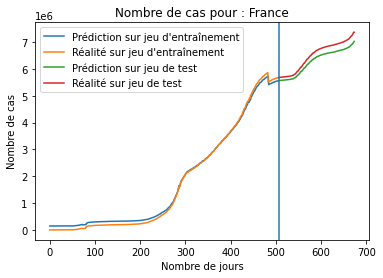

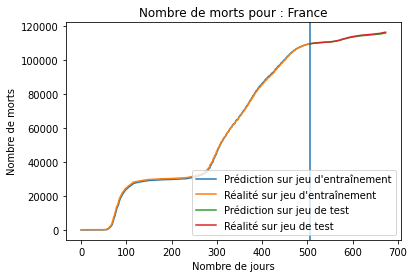

In [18]:
def display_plot_lstm(model, scaler, trainX, trainY, testX, testY, country, ord_context):
  daysTrain = range(len(trainX))
  daysTest = np.array(range(len(testX))) + len(daysTrain)
  plt.plot(daysTrain, scaler.inverse_transform(model.predict(trainX)), '-', label="Prédiction sur jeu d'entraînement")
  plt.plot(daysTrain, scaler.inverse_transform(np.reshape(trainY, (-1, 1))), '-', label="Réalité sur jeu d'entraînement")

  plt.plot(daysTest, scaler.inverse_transform(model.predict(testX)), '-', label="Prédiction sur jeu de test")
  plt.plot(daysTest, scaler.inverse_transform(np.reshape(testY, (-1, 1))), '-', label="Réalité sur jeu de test")

  plt.axvline(len(trainX), 0, 1)
  plt.legend()
  plt.title("Nombre de " + ord_context + " pour : " + country)
  plt.xlabel("Nombre de jours")
  plt.ylabel("Nombre de " + ord_context)
  plt.show()

display_plot_lstm(confirmed_lstm, confirmed_scaler, confirmed_trainX, confirmed_trainY, confirmed_testX, confirmed_testY, country, "cas")
display_plot_lstm(deaths_lstm, deaths_scaler, deaths_trainX, deaths_trainY, deaths_testX, deaths_testY, country, "morts")

In [19]:
days = 120
predictions = []
test = [[0.5]]
print(test)
start_day = len(confirmed_trainX)
print(start_day)
for i in range(days):
    pred = confirmed_lstm.predict(test)
    predictions.append(pred)
    test = pred
    print(test)

[[0.5]]
506
[[0.4725765]]
[[0.44747102]]
[[0.42438918]]
[[0.40308756]]
[[0.383362]]
[[0.3650396]]
[[0.3479736]]
[[0.3320378]]
[[0.3171234]]
[[0.30313587]]
[[0.2899922]]
[[0.27762002]]
[[0.2659551]]
[[0.2549407]]
[[0.2445259]]
[[0.23466544]]
[[0.22531874]]
[[0.21644922]]
[[0.20802377]]
[[0.20001246]]
[[0.19238792]]
[[0.18512534]]
[[0.17820208]]
[[0.17159738]]
[[0.16529222]]
[[0.15926884]]
[[0.15351109]]
[[0.14800413]]
[[0.1427341]]
[[0.13768806]]
[[0.13285421]]
[[0.12822141]]
[[0.12377937]]
[[0.11951829]]
[[0.11542927]]
[[0.11150385]]
[[0.10773407]]
[[0.10411261]]
[[0.1006325]]
[[0.09728707]]
[[0.09407024]]
[[0.09097607]]
[[0.08799924]]
[[0.08513452]]
[[0.08237691]]
[[0.07972179]]
[[0.07716484]]
[[0.07470192]]
[[0.07232897]]
[[0.07004242]]
[[0.06783862]]
[[0.0657142]]
[[0.06366597]]
[[0.06169088]]
[[0.05978601]]
[[0.05794849]]
[[0.05617572]]
[[0.05446522]]
[[0.05281462]]
[[0.05122148]]
[[0.04968373]]
[[0.04819922]]
[[0.04676592]]
[[0.04538198]]
[[0.04404548]]
[[0.04275471]]
[[0.04150797

# Variables multi-dimensionnelles

In [20]:
time_steps = 10
n_features = 2

### Get new data


In [21]:
df_raw_stringency_index = pd.read_csv("covid-stringency-index.csv")
df_raw_stringency_index_country = df_raw_stringency_index[df_raw_stringency_index["Entity"] == country]
df_stringency_index_country = df_raw_stringency_index_country.drop(columns=["Entity", "Code"])
df_stringency_index_country.drop(index=df_stringency_index_country.index[0], axis=0, inplace=True)

stringency_index_values = list(df_stringency_index_country.stringency_index)[:len(confirmed_country_values)]
stringency_index_days = [i for i in range(df_stringency_index_country.Day.size)]

### Adjust some data length (all equal)

In [22]:
confirmed_country_values = confirmed_country_values[:len(stringency_index_values)]
confirmed_country_days = confirmed_country_days[:len(stringency_index_values)]

deaths_country_values = deaths_country_values[:len(stringency_index_values)]
deaths_country_days = deaths_country_days[:len(stringency_index_values)]

### Print on a plot

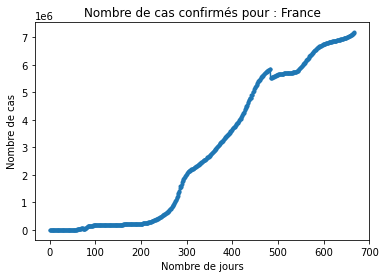

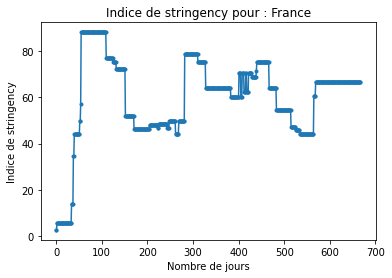

In [23]:
plt.plot(confirmed_country_days, confirmed_country_values, '.-')
plt.title("Nombre de cas confirmés pour : " + country)
plt.xlabel("Nombre de jours")
plt.ylabel("Nombre de cas")
plt.show()

plt.plot(stringency_index_days, stringency_index_values, '.-')
plt.title("Indice de stringency pour : " + country)
plt.xlabel("Nombre de jours")
plt.ylabel("Indice de stringency")
plt.show()

### Create data sets

In [24]:
# Scaled values
confirmed_scaler = MinMaxScaler((-1, 1))
deaths_scaler = MinMaxScaler((-1, 1))
stringency_scaler = MinMaxScaler((-1, 1))

confirmed_scaler.fit(confirmed_country_values.reshape((-1, 1)))
scaled_confirmed = confirmed_scaler.transform(confirmed_country_values.reshape((-1, 1))).reshape((-1,))

deaths_scaler.fit(deaths_country_values.reshape((-1, 1)))
scaled_deaths = deaths_scaler.transform(deaths_country_values.reshape((-1, 1))).reshape((-1,))

stringency_scaler.fit(np.array(stringency_index_values).reshape((-1, 1)))
scaled_stringency = stringency_scaler.transform(np.array(stringency_index_values).reshape((-1, 1))).reshape((-1,))

In [25]:
multi_data = list(zip(scaled_confirmed, scaled_stringency))

In [26]:
multi_train, multi_test, _ = create_lstm_sets(multi_data, time_steps, scale=False, train_percent=0.70)
multi_trainX, multi_trainY = multi_train
multi_testX, multi_testY = multi_test

In [27]:
def lstm_network_multi(X, Y, time_steps=1, n_features=1):
  model = kr.Sequential()
  model.add(kr.layers.LSTM(200, input_shape=(time_steps, n_features), return_sequences=True)) #return_sequences=True
  model.add(kr.layers.Dropout(0.1))
  model.add(kr.layers.LSTM(400))
  model.add(kr.layers.Dropout(0.1))
  model.add(kr.layers.Dense(1))
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(loss='mean_squared_error', optimizer=opt)
  model.summary()
  model.fit(X, Y, epochs=20, batch_size=6);
  return model

In [28]:
multi_lstm = lstm_network_multi(multi_trainX, multi_trainY, time_steps, n_features)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 200)           162400    
                                                                 
 dropout_4 (Dropout)         (None, 10, 200)           0         
                                                                 
 lstm_5 (LSTM)               (None, 400)               961600    
                                                                 
 dropout_5 (Dropout)         (None, 400)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 401       
                                                                 
Total params: 1,124,401
Trainable params: 1,124,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
77/77 [==========================

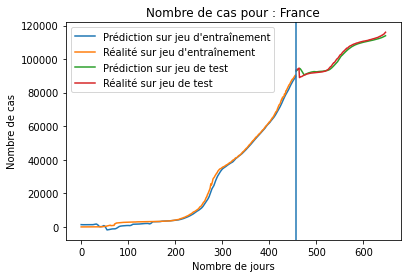

In [29]:
display_plot_lstm(multi_lstm, deaths_scaler, multi_trainX, multi_trainY, multi_testX, multi_testY, country, "cas")

In [30]:
n_days = 150
predictions = []
test = multi_trainX[-1]
test = test.reshape(-1, time_steps, n_features)
start_day = len(multi_trainX)
print(start_day)
print(test)
for i in range(n_days):
    pred = multi_lstm.predict(test)
    predictions.append(pred[0][0])
    
    old = test[0][0]
    test = np.delete(test[0], 0, axis=0)

    indice = stringency_scaler.transform([[50]])
    if i > 75:
        indice = stringency_scaler.transform([[65]])

    test = np.append(test, [pred[0][0], indice[0][0]]).reshape(-1, time_steps, n_features)

    print(pred)

457
[[[0.49332378 0.69570322]
  [0.50224219 0.69570322]
  [0.51127996 0.69570322]
  [0.51804946 0.69570322]
  [0.51926692 0.69570322]
  [0.52739966 0.69570322]
  [0.53608048 0.69570322]
  [0.54343728 0.69570322]
  [0.55015169 0.69570322]
  [0.55724363 0.69570322]]]
[[0.5430489]]
[[0.54668546]]
[[0.54858005]]
[[0.5497245]]
[[0.5509128]]
[[0.5529276]]
[[0.5552047]]
[[0.5577022]]
[[0.5604771]]
[[0.5634717]]
[[0.56651837]]
[[0.56861675]]
[[0.57063967]]
[[0.5727395]]
[[0.57496536]]
[[0.57729334]]
[[0.5796368]]
[[0.58196765]]
[[0.58426535]]
[[0.5865067]]
[[0.5886751]]
[[0.590769]]
[[0.5928743]]
[[0.59499156]]
[[0.597109]]
[[0.59921163]]
[[0.60128784]]
[[0.6033366]]
[[0.605357]]
[[0.60735196]]
[[0.6093251]]
[[0.61128026]]
[[0.61322206]]
[[0.6151481]]
[[0.61705494]]
[[0.6189403]]
[[0.62080437]]
[[0.6226481]]
[[0.624472]]
[[0.6262778]]
[[0.62806535]]
[[0.6298348]]
[[0.6315858]]
[[0.63331866]]
[[0.63503295]]
[[0.6367287]]
[[0.6384058]]
[[0.6400651]]
[[0.641707]]
[[0.6433308]]
[[0.6449376]]
[[0.6

In [31]:
predicted_plot = np.concatenate((confirmed_scaler.transform(confirmed_country_values[:start_day].reshape((-1, 1))).reshape((-1,)), predictions))
predicted_plot = confirmed_scaler.inverse_transform(predicted_plot.reshape((-1, 1)))

days = np.concatenate((list(range(start_day)), np.array([day for day in range(start_day, start_day+n_days)])))

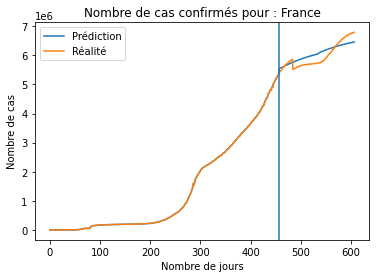

In [32]:
plt.plot(days, predicted_plot, '-', label="Prédiction")
plt.plot(days, confirmed_country_values[:start_day+n_days], '-', label="Réalité")
plt.legend()
plt.axvline(start_day)
plt.title("Nombre de cas confirmés pour : " + country)
plt.xlabel("Nombre de jours")
plt.ylabel("Nombre de cas")
plt.show()